In [36]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [39]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_meta_path = data_dir / '9PPI Cell Culture' / 'Whole' / 'metadata' / 'imgs_reg_norm.csv'
df_imgs = pd.read_csv(df_meta_path)

# Segmentation 

In [6]:
from skimage import exposure, util

def contrast_str(img, n_min=0.01, n_max=99.95):
    p2, p98 = np.percentile(img, (n_min, n_max))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    img_rescale = util.img_as_ubyte(img_rescale)
    return img_rescale

In [7]:
whole_seg_path = data_dir / '9PPI Cell Culture' / 'Whole' / 'imgs' / 'segmentation'
mask_path = data_dir / '9PPI Cell Culture' / 'Whole' / 'imgs' / 'masks'

mask_path.mkdir(parents=True, exist_ok=True)

In [8]:
from cellpose import core, utils, io, models, metrics
use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')


>>> GPU activated? YES


In [10]:
# Cyto segmentaion
masks = []
for p in os.listdir(whole_seg_path):
    img = skimage.io.imread(whole_seg_path / p).transpose((2,0,1))
    
    # Cyto segmentation
    model = models.CellposeModel(gpu=True, model_type='cyto2')
    mask_cyto, flows, styles = model.eval(img, 
                                  channels=[2,3],
                                  diameter=180,
                                  flow_threshold=0.6,
                                  cellprob_threshold=-3
                                  )
    
    file_path = mask_path / p
    tiff.imwrite(file_path, mask_cyto)
    
    # Nuclei segemtnation
    model = models.CellposeModel(gpu=True, model_type='nuclei')
    mask_nuclei, flows, styles = model.eval(img, 
                                  channels=[3,0],
                                  diameter=100,
                                  flow_threshold=0.6,
                                  )
    
        
    file_path = mask_path / f'Nuclei_{p}'
    tiff.imwrite(file_path, mask_nuclei)

In [ ]:
# fig, ax = plt.subplots()
# ax.imshow(mask_cyto, cmap=plt.cm.gray)
# for n, contour in enumerate(contours_cyto):
#     contour = max(contour, key = len)
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=1)
# for n, contour in enumerate(contours_nuclei):
#     contour = max(contour, key = len)
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=1)


# Spot Detection

In [5]:
# ['Hoeschst' 'Cyclin D1 & CDK2' 'NF-Kb & p-P90rsk' 'Hoeschst' 'Sox2 & Oct4'
#  'Bim & Tom20' 'Hoeschst' 'Mcl-1 & BAK' 'Hoeschst' 'p-ERK & c-MYC'
#  'Hoeschst' 'TEAD1 & YAP' 'Hoeschst' 'Cyclin E & CDK4' 'Hoeschst'
#  'P-AKT & mTOR' 'Hoeschst' 'p-EGFR' 'Phalloidin' 'Ki67' 'Hoeschst'
#  'Cyclin D1 & CDK2 - re' 'NF-Kb & p-P90rsk - re' 'Hoeschst' 'NBD-C6'
#  'Golph4' 'COX IV' 'Hoeschst' 'Pan-cytokeratin' 'Hoeschst'
#  'Concanavalin A' 'WGA']

In [6]:
import PLA

PPI_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'PPI'
PPI_save_path.mkdir(parents=True, exist_ok=True)

In [15]:
PPI_names = ['Cyclin D1 & CDK2', 'NF-Kb & p-P90rsk', 'Sox2 & Oct4', 'Bim & Tom20', 'Mcl-1 & BAK', 
             'p-ERK & c-MYC', 'TEAD1 & YAP',  'Cyclin E & CDK4', 'P-AKT & mTOR', 'Cyclin D1 & CDK2 - re', 'NF-Kb & p-P90rsk - re']

for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    pla_detect = PLA.PLA_detection(path)
    
    imgs_spots = []
    imgs_wths = []
    for PPI_pair in tqdm(PPI_names): 
        # if PPI_pair in ['Cyclin D1 & CDK2', 'NF-Kb & p-P90rsk']:
        #     thres = 0.1
        # else:
        #     thres = 0.05
        img_spot, img_wth,_,_ = pla_detect.detect_spot(PPI_pair, thres=0.04)
        imgs_spots.append(img_spot)
        imgs_wths.append(img_wth)

    # # Save PPI dict
    name = '_'.join(row[1:3])+'.pkl'
    pla_detect.save_pickle(PPI_save_path / name)
    

  0%|          | 0/11 [00:00<?, ?it/s]

Reading image Cyclin D1 & CDK2
Processing image Cyclin D1 & CDK2
(array([0, 1], dtype=uint8), array([28674924,   936602], dtype=int64))
Reading image NF-Kb & p-P90rsk
Processing image NF-Kb & p-P90rsk
(array([0, 1], dtype=uint8), array([29392709,   218817], dtype=int64))
Reading image Sox2 & Oct4
Processing image Sox2 & Oct4
(array([0, 1], dtype=uint8), array([29360904,   250622], dtype=int64))
Reading image Bim & Tom20
Processing image Bim & Tom20
(array([0, 1], dtype=uint8), array([29472262,   139264], dtype=int64))
Reading image Mcl-1 & BAK
Processing image Mcl-1 & BAK
(array([0, 1], dtype=uint8), array([29598983,    12543], dtype=int64))
Reading image p-ERK & c-MYC
Processing image p-ERK & c-MYC
(array([0, 1], dtype=uint8), array([29516427,    95099], dtype=int64))
Reading image TEAD1 & YAP
Processing image TEAD1 & YAP
(array([0, 1], dtype=uint8), array([29599225,    12301], dtype=int64))
Reading image Cyclin E & CDK4
Processing image Cyclin E & CDK4
(array([0, 1], dtype=uint8), ar

  0%|          | 0/11 [00:00<?, ?it/s]

Reading image Cyclin D1 & CDK2
Processing image Cyclin D1 & CDK2
(array([0, 1], dtype=uint8), array([28257387,  1343813], dtype=int64))
Reading image NF-Kb & p-P90rsk
Processing image NF-Kb & p-P90rsk
(array([0, 1], dtype=uint8), array([29285340,   315860], dtype=int64))
Reading image Sox2 & Oct4
Processing image Sox2 & Oct4
(array([0, 1], dtype=uint8), array([29241808,   359392], dtype=int64))
Reading image Bim & Tom20
Processing image Bim & Tom20
(array([0, 1], dtype=uint8), array([29414122,   187078], dtype=int64))
Reading image Mcl-1 & BAK
Processing image Mcl-1 & BAK
(array([0, 1], dtype=uint8), array([29577720,    23480], dtype=int64))
Reading image p-ERK & c-MYC
Processing image p-ERK & c-MYC
(array([0, 1], dtype=uint8), array([29466617,   134583], dtype=int64))
Reading image TEAD1 & YAP
Processing image TEAD1 & YAP
(array([0, 1], dtype=uint8), array([29579165,    22035], dtype=int64))
Reading image Cyclin E & CDK4
Processing image Cyclin E & CDK4
(array([0, 1], dtype=uint8), ar

  0%|          | 0/11 [00:00<?, ?it/s]

Reading image Cyclin D1 & CDK2
Processing image Cyclin D1 & CDK2
(array([0, 1], dtype=uint8), array([28999810,   663362], dtype=int64))
Reading image NF-Kb & p-P90rsk
Processing image NF-Kb & p-P90rsk
(array([0, 1], dtype=uint8), array([29480748,   182424], dtype=int64))
Reading image Sox2 & Oct4
Processing image Sox2 & Oct4
(array([0, 1], dtype=uint8), array([29488507,   174665], dtype=int64))
Reading image Bim & Tom20
Processing image Bim & Tom20
(array([0, 1], dtype=uint8), array([29548315,   114857], dtype=int64))
Reading image Mcl-1 & BAK
Processing image Mcl-1 & BAK
(array([0, 1], dtype=uint8), array([29652428,    10744], dtype=int64))
Reading image p-ERK & c-MYC
Processing image p-ERK & c-MYC
(array([0, 1], dtype=uint8), array([29596462,    66710], dtype=int64))
Reading image TEAD1 & YAP
Processing image TEAD1 & YAP
(array([0, 1], dtype=uint8), array([29648783,    14389], dtype=int64))
Reading image Cyclin E & CDK4
Processing image Cyclin E & CDK4
(array([0, 1], dtype=uint8), ar

  0%|          | 0/11 [00:00<?, ?it/s]

Reading image Cyclin D1 & CDK2
Processing image Cyclin D1 & CDK2
(array([0, 1], dtype=uint8), array([28999257,   617411], dtype=int64))
Reading image NF-Kb & p-P90rsk
Processing image NF-Kb & p-P90rsk
(array([0, 1], dtype=uint8), array([29443308,   173360], dtype=int64))
Reading image Sox2 & Oct4
Processing image Sox2 & Oct4
(array([0, 1], dtype=uint8), array([29451866,   164802], dtype=int64))
Reading image Bim & Tom20
Processing image Bim & Tom20
(array([0, 1], dtype=uint8), array([29479577,   137091], dtype=int64))
Reading image Mcl-1 & BAK
Processing image Mcl-1 & BAK
(array([0, 1], dtype=uint8), array([29604769,    11899], dtype=int64))
Reading image p-ERK & c-MYC
Processing image p-ERK & c-MYC
(array([0, 1], dtype=uint8), array([29538736,    77932], dtype=int64))
Reading image TEAD1 & YAP
Processing image TEAD1 & YAP
(array([0, 1], dtype=uint8), array([29599298,    17370], dtype=int64))
Reading image Cyclin E & CDK4
Processing image Cyclin E & CDK4
(array([0, 1], dtype=uint8), ar

In [16]:
# viewer = napari.view_image(np.stack(imgs_wths))
# viewer.add_image(img_marker)
# viewer.add_image(np.stack(imgs_spots), contrast_limits=[0,1])

In [17]:
# with h5py.File(path, "r") as f:
#     imgs = f['imgs'][:]
#     markers = f['imgs'].attrs['Marker']

In [18]:
# napari.view_image(imgs, channel_axis=0, name=markers, visible=False, contrast_limits=[0,1])

# Extract cell info

In [5]:
from skimage import morphology, measure
from skimage.segmentation import clear_border
    
def count_pixel_label_mask(regionmask, intensity_image):
    v,c = np.unique(intensity_image[regionmask], return_counts=True)
    return dict(zip(v,c))
    
# Quality control of mask
def qc_nuclei(mask_cyto, mask_nuclei, small_size=2000):
    '''
    Function to check if cell masks contain nuclei
    '''
    # Dictionnary storing nuclei and cyto label to cell id 
    nuclei2cell = {}
    cyto2cell = {}
    
    # Filter out small objects
    mask_cyto = morphology.remove_small_objects(mask_cyto,  min_size=small_size)
    
    # Filter out mask touching border
    mask_cyto = clear_border(mask_cyto)
    
    # Filtered only cell mask region
    cell_mask = np.where(mask_cyto > 0, 1, 0)
    mask_nuclei_filtered = mask_nuclei * cell_mask
    mask_nuclei_filtered =  morphology.remove_small_objects(mask_nuclei_filtered,  min_size=small_size)
    
    nuclei_mask = np.where(mask_nuclei>0, 1, 0)
    cyto = (mask_cyto - mask_cyto*nuclei_mask).astype(np.uint16)
    
    # Count pixel cell label in each nuclei region to assign each nuclei to cell
    props = measure.regionprops(mask_nuclei_filtered, intensity_image=mask_cyto, 
                    extra_properties=(count_pixel_label_mask,))
    nuclei_labels = []
    cell_labels = []
    for prop in props:
        df = pd.DataFrame.from_dict(prop['count_pixel_label_mask'], orient='index').reset_index()
        df.columns = ['Label', 'Count']
        corresponding_label = df.iloc[df['Count'].argmax(axis=0)]['Label']
        nuclei_labels.append(prop['Label'])
        cell_labels.append(corresponding_label)
    
    df = pd.DataFrame({'Nuclei': nuclei_labels, 'Cyto': cell_labels})
    return mask_cyto, mask_nuclei_filtered, cyto, df

In [7]:
from collections import defaultdict

data_dir = (Path().cwd().parents[0] / 'data').absolute()

# Get image dataframe 
df_imgs_path = data_dir / '9PPI Cell Culture' / 'Whole' / 'metadata' / 'imgs_reg_norm.csv'
df_imgs = pd.read_csv(df_imgs_path)


In [8]:
# Read masks paths 
mask_dir = data_dir / '9PPI Cell Culture' / 'Whole' / 'imgs' / 'masks'
mask_filt_dir = data_dir / '9PPI Cell Culture' / 'Whole' / 'imgs' / 'masks_filtered'
mask_filt_dir.mkdir(parents=True, exist_ok=True)

masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_dir / path
    else:
        masks_path[name]['cyto'] = mask_dir / path

In [9]:
for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cyto']
    mask_nuclei_path = masks_path[name]['nuclei']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    
    cell, nuclei, cyto, df = qc_nuclei(mask_cyto, mask_nuclei)
    
    file_path =  mask_filt_dir / f'Nuclei_{name}.tif'
    tiff.imwrite(file_path, nuclei)
    file_path =  mask_filt_dir / f'Cell_{name}.tif'
    tiff.imwrite(file_path, cell)
    file_path =  mask_filt_dir / f'Cyto_{name}.tif'
    tiff.imwrite(file_path, cyto)
    file_path =  mask_filt_dir / f'df_{name}.csv'
    df.to_csv(file_path, index=False)

In [10]:
# import napari

# viewer = napari.view_labels(cell)
# viewer.add_labels(nuclei)

# Extract cell contours

In [11]:
from skimage import measure
import cv2 

def get_contours_mask(mask):
    contours = []
    labels = []
    for l in tqdm(np.unique(mask)):
        if l == 0:
            continue
        contours.append(measure.find_contours((mask==l).astype(np.uint8), 0.8))
        labels.append(l)
    return contours, labelsa

def replace_with_dict2(ar, dic):
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()
    
    ks = k[sidx]
    vs = v[sidx]
    return vs[np.searchsorted(ks,ar)]

In [12]:
mask_filt_dir = data_dir / '9PPI Cell Culture' / 'Whole' / 'imgs' / 'masks_filtered'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [13]:
contour_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'contours'
contour_save_path.mkdir(parents=True, exist_ok=True)

for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    df_cell_info = pd.read_csv(df_path)
    nuclei2cell = dict(zip(df_cell_info.iloc[:,0], df_cell_info.iloc[:,1]))   
    replaced = replace_with_dict2(mask_nuclei, nuclei2cell)
    
    # Extract contours
    contours_cyto, labels_cyto = get_contours_mask(mask_cyto)
    contours_nuclei, labels_nuclei = get_contours_mask(replaced)
    
    # Save data
    save_path = contour_save_path / (name+'.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump([contours_cyto, labels_cyto, contours_nuclei, labels_nuclei], 
                    f, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

  0%|          | 0/494 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/308 [00:00<?, ?it/s]

# Extract per cell PPI count

In [14]:
import pickle 

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def create_PPI_df(PPI_labels, PPI_loc, name, cyto=True):
    if cyto:
        columns_name = ['Cyto', 'x', 'y']
    else:
        columns_name = ['Nuclei', 'x', 'y']
    df = pd.DataFrame(np.hstack([PPI_labels[:,np.newaxis], PPI_loc]), 
                      columns=columns_name)
    df['PPI'] = name
    return df

In [15]:
mask_filt_dir = data_dir / '9PPI Cell Culture' / 'Whole' / 'imgs' / 'masks_filtered'
PPI_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'PPI'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [16]:
for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    df_cell_info = pd.read_csv(df_path)
    nuclei2cell = dict(zip(df_cell_info.iloc[:,0], df_cell_info.iloc[:,1]))   
    
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')
    dfs_PPI_cyto = []
    dfs_PPI_nuclei = []
    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)
        
        # Cyto
        PPI_labels = mask_cyto[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k)
        dfs_PPI_cyto.append(df_PPI)
        
        # Nuclei
        PPI_labels = mask_nuclei[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k, cyto=False)
        dfs_PPI_nuclei.append(df_PPI)
    
    # Combined DFs
    df_PPI_cyto = pd.concat(dfs_PPI_cyto)
    df_PPI_nuclei = pd.concat(dfs_PPI_nuclei)
    df_PPI_nuclei['Nuclei'] = df_PPI_nuclei['Nuclei'].apply(lambda x: nuclei2cell.get(x,x))   
    df_merged = df_PPI_cyto.merge(df_PPI_nuclei)
    df_merged['Condition'] = row[1]
    df_merged['FOV'] = row[2]
    
    # Save dataframe
    path = PPI_save_path / f'{name}.csv'
    df_merged.to_csv(path, index=False)

# Generate PPI network

In [40]:
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
from sklearn import preprocessing
from libpysal import weights
from itertools import count
from libpysal.cg import voronoi_frames
import scipy 
from scipy.spatial import Delaunay
import itertools
import pickle

def create_network(df, t=50, scale=0.2):   
    y,x = df['y'].to_numpy(), df['x'].to_numpy()

    # Get coordinates
    coordinates = np.vstack([x, y]).T
    points = coordinates - np.mean(coordinates, axis=0)
    
    # Delaunay
    tri = Delaunay(points)
    G = nx.Graph()
    for path in tri.simplices:
        G.add_nodes_from(path)
        edges = list(itertools.combinations(path, 2))
        G.add_edges_from(edges)
    
    # Euclidian distance
    distance = scipy.spatial.distance_matrix(points, points)
    l = t**2/np.log(t)
    distance_norm = np.exp(-distance**2/t)

    # distance_norm = np.where(distance>t, 0, np.exp(-distance*2/l))
    
    g_dist = nx.from_numpy_array(distance_norm)
    g = g_dist.edge_subgraph(G.edges()).copy() # Only keep delaunay edges
    nx.set_node_attributes(g, dict(zip(g.nodes(), df.Labels)), "labels")
    nuclei = (df.Nuclei > 0).astype(int).tolist()
    nx.set_node_attributes(g, dict(zip(g.nodes(), nuclei)), "nuclei")
    nx.set_node_attributes(g, dict(zip(g.nodes(), coordinates)), "pos")
    return g

def create_network3(df, t=50):    
    # Get coordinates
    coordinates = np.column_stack((df.x, df.y))
    points = coordinates - np.mean(coordinates, axis=0)
    
    # Delaunay
    vcells, generators = voronoi_frames(points, clip="chull")
    delaunay = weights.Rook.from_dataframe(vcells)
    g_de = delaunay.to_networkx()  
    
    # Euclidian distance
    distance = scipy.spatial.distance_matrix(points, points)
    l = t**2/np.log(t)
    distance_norm = np.exp(-distance**2/t)

    # distance_norm = np.where(distance>t, 0, np.exp(-distance*2/l))
    
    g_dist = nx.from_numpy_array(distance_norm)
    g = g_dist.edge_subgraph(g_de.edges()).copy() # Only keep delaunay edges
    nx.set_node_attributes(g, dict(zip(g.nodes(), df.Labels)), "labels")
    nuclei = (df.Nuclei > 0).astype(int).tolist()
    nx.set_node_attributes(g, dict(zip(g.nodes(), nuclei)), "nuclei")
    nx.set_node_attributes(g, dict(zip(g.nodes(), coordinates)), "pos")
    return g

In [41]:
PPI_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'PPI'

# Read PPi info 
dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)
df = pd.concat(dfs)
df = df[df.PPI.isin(['Cyclin D1 & CDK2', 'NF-Kb & p-P90rsk', 'Sox2 & Oct4',
       'Bim & Tom20', 'Mcl-1 & BAK', 'p-ERK & c-MYC', 'TEAD1 & YAP',
       'Cyclin E & CDK4', 'P-AKT & mTOR'])]

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df['Labels'] = labels.tolist()

In [53]:
graph_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'graphs' / 'raw'
graph_save_path.mkdir(parents=True, exist_ok=True)

group = df.groupby(['Condition', 'FOV', 'Cyto'])
for name, df_group in tqdm(group, total=len(group)):
    if name[2] == 0:
        continue
    if len(df_group) < 5:
        continue
    
    # Remove duplicated 
    df_group.drop_duplicates(subset=['x', 'y', 'PPI'],
                             keep='first', inplace=True)
    
    # Add small variatio to close PPI 
    while df_group.duplicated(subset=['x', 'y']).any():
        df_group.loc[df_group.duplicated(subset=['x', 'y']), ['x', 'y']] += [1,1] 
    
    # Generate graph and info
    g = create_network(df_group)
    if nx.number_of_isolates(g)>0:
        print('Isolated nodes')
        
    # Save pgrahs
    save_path = graph_save_path / ('_'.join([str(n) for n in name])+'.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(g, f, protocol=pickle.HIGHEST_PROTOCOL)
    

  0%|          | 0/1495 [00:00<?, ?it/s]

In [ ]:
# group = df.groupby(['Condition', 'FOV', 'Cyto'])
# for name, df_group in tqdm(group, total=len(group)):
#     if name[2] == 0:
#         continue
#     if len(df_group) < 5:
#         continue
    
#     # Remove duplicated 
#     df_group.drop_duplicates(subset=['x', 'y', 'PPI'],
#                              keep='first', inplace=True)
    
#     # Add small variatio to close PPI 
#     while df_group.duplicated(subset=['x', 'y']).any():
#         df_group.loc[df_group.duplicated(subset=['x', 'y']), ['x', 'y']] += [1,1] 
    
#     if df_group.duplicated(subset=['x', 'y']).any():
#         break

  0%|          | 0/1495 [00:00<?, ?it/s]

In [ ]:
len(group)

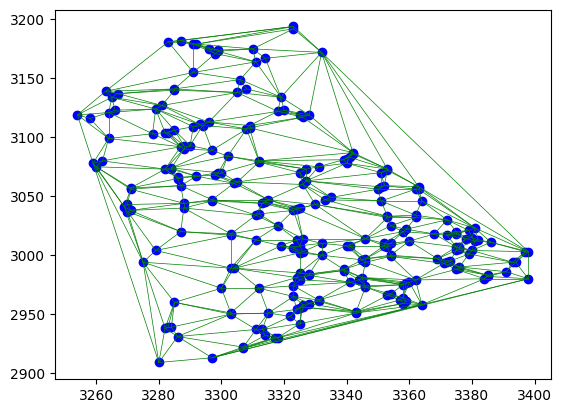

In [35]:
y,x = df_group['y'].to_numpy(), df_group['x'].to_numpy()

points = np.vstack([x, y]).T
tri = Delaunay(points)

G = nx.Graph()
for path in tri.simplices:
    G.add_nodes_from(path)
    edges = list(itertools.combinations(path, 2))
    G.add_edges_from(edges)
    
pos = points
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot()

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, color='b')
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color='g', lw=0.5)